# Week 13 Demo

This exercise involves paper data taken from the [HCI Bibliography](http://hcibib.org/); in particular, abstracts for papers at CHI (the human-computer interaction conference).

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

## Load Data

In [6]:
papers = pd.read_csv('chi-papers.csv', encoding='utf8')
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13403 entries, 0 to 13402
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        13292 non-null  object 
 1   year      13370 non-null  float64
 2   title     13370 non-null  object 
 3   keywords  3504 non-null   object 
 4   abstract  12872 non-null  object 
dtypes: float64(1), object(4)
memory usage: 523.7+ KB


Let's treat empty abstracts as empty strings:

In [16]:
papers['abstract'].fillna('', inplace=True)
papers['title'].fillna('', inplace=True)

For some purposes, we want *all text*.  Let's make a field:

In [17]:
papers['all_text'] = papers['title'] + ' ' + papers['abstract']

## Counting

Now that you have this, let's go!

Set up a `CountVectorizer` to tokenize the words and compute counts:

In [9]:
vec = CountVectorizer(encoding='utf8')

You can use the `sum` method on a sparse matrix to sum up entries. If you sum the *columns* (specify `axis=0`), you will get an array of word counts:

In [10]:
mat = vec.fit_transform(papers['abstract'])
mat

<13403x27315 sparse matrix of type '<class 'numpy.int64'>'
	with 991576 stored elements in Compressed Sparse Row format>

In [11]:
abs_counts = np.array(mat.sum(axis=0)).flatten()

Plot the distribution of the log of word counts.

## Classifying

Train a classifier to predict whether a paper was written before 2000 or after (predict "recent" where "recent" is where the year is >= 2000).

Use either Naive Bayes or k-NN.

## Factorizing

Compute a TruncatedSVD with 10 features from *all* text words.

In [27]:
svd = Pipeline([
    ('tokenize', CountVectorizer()),
    ('svd', TruncatedSVD(10))
])
svd_X = svd.fit_transform(papers['all_text'])

What does the pairplot of these dimensions look like? (Week 13 demo notebook is helpful!)

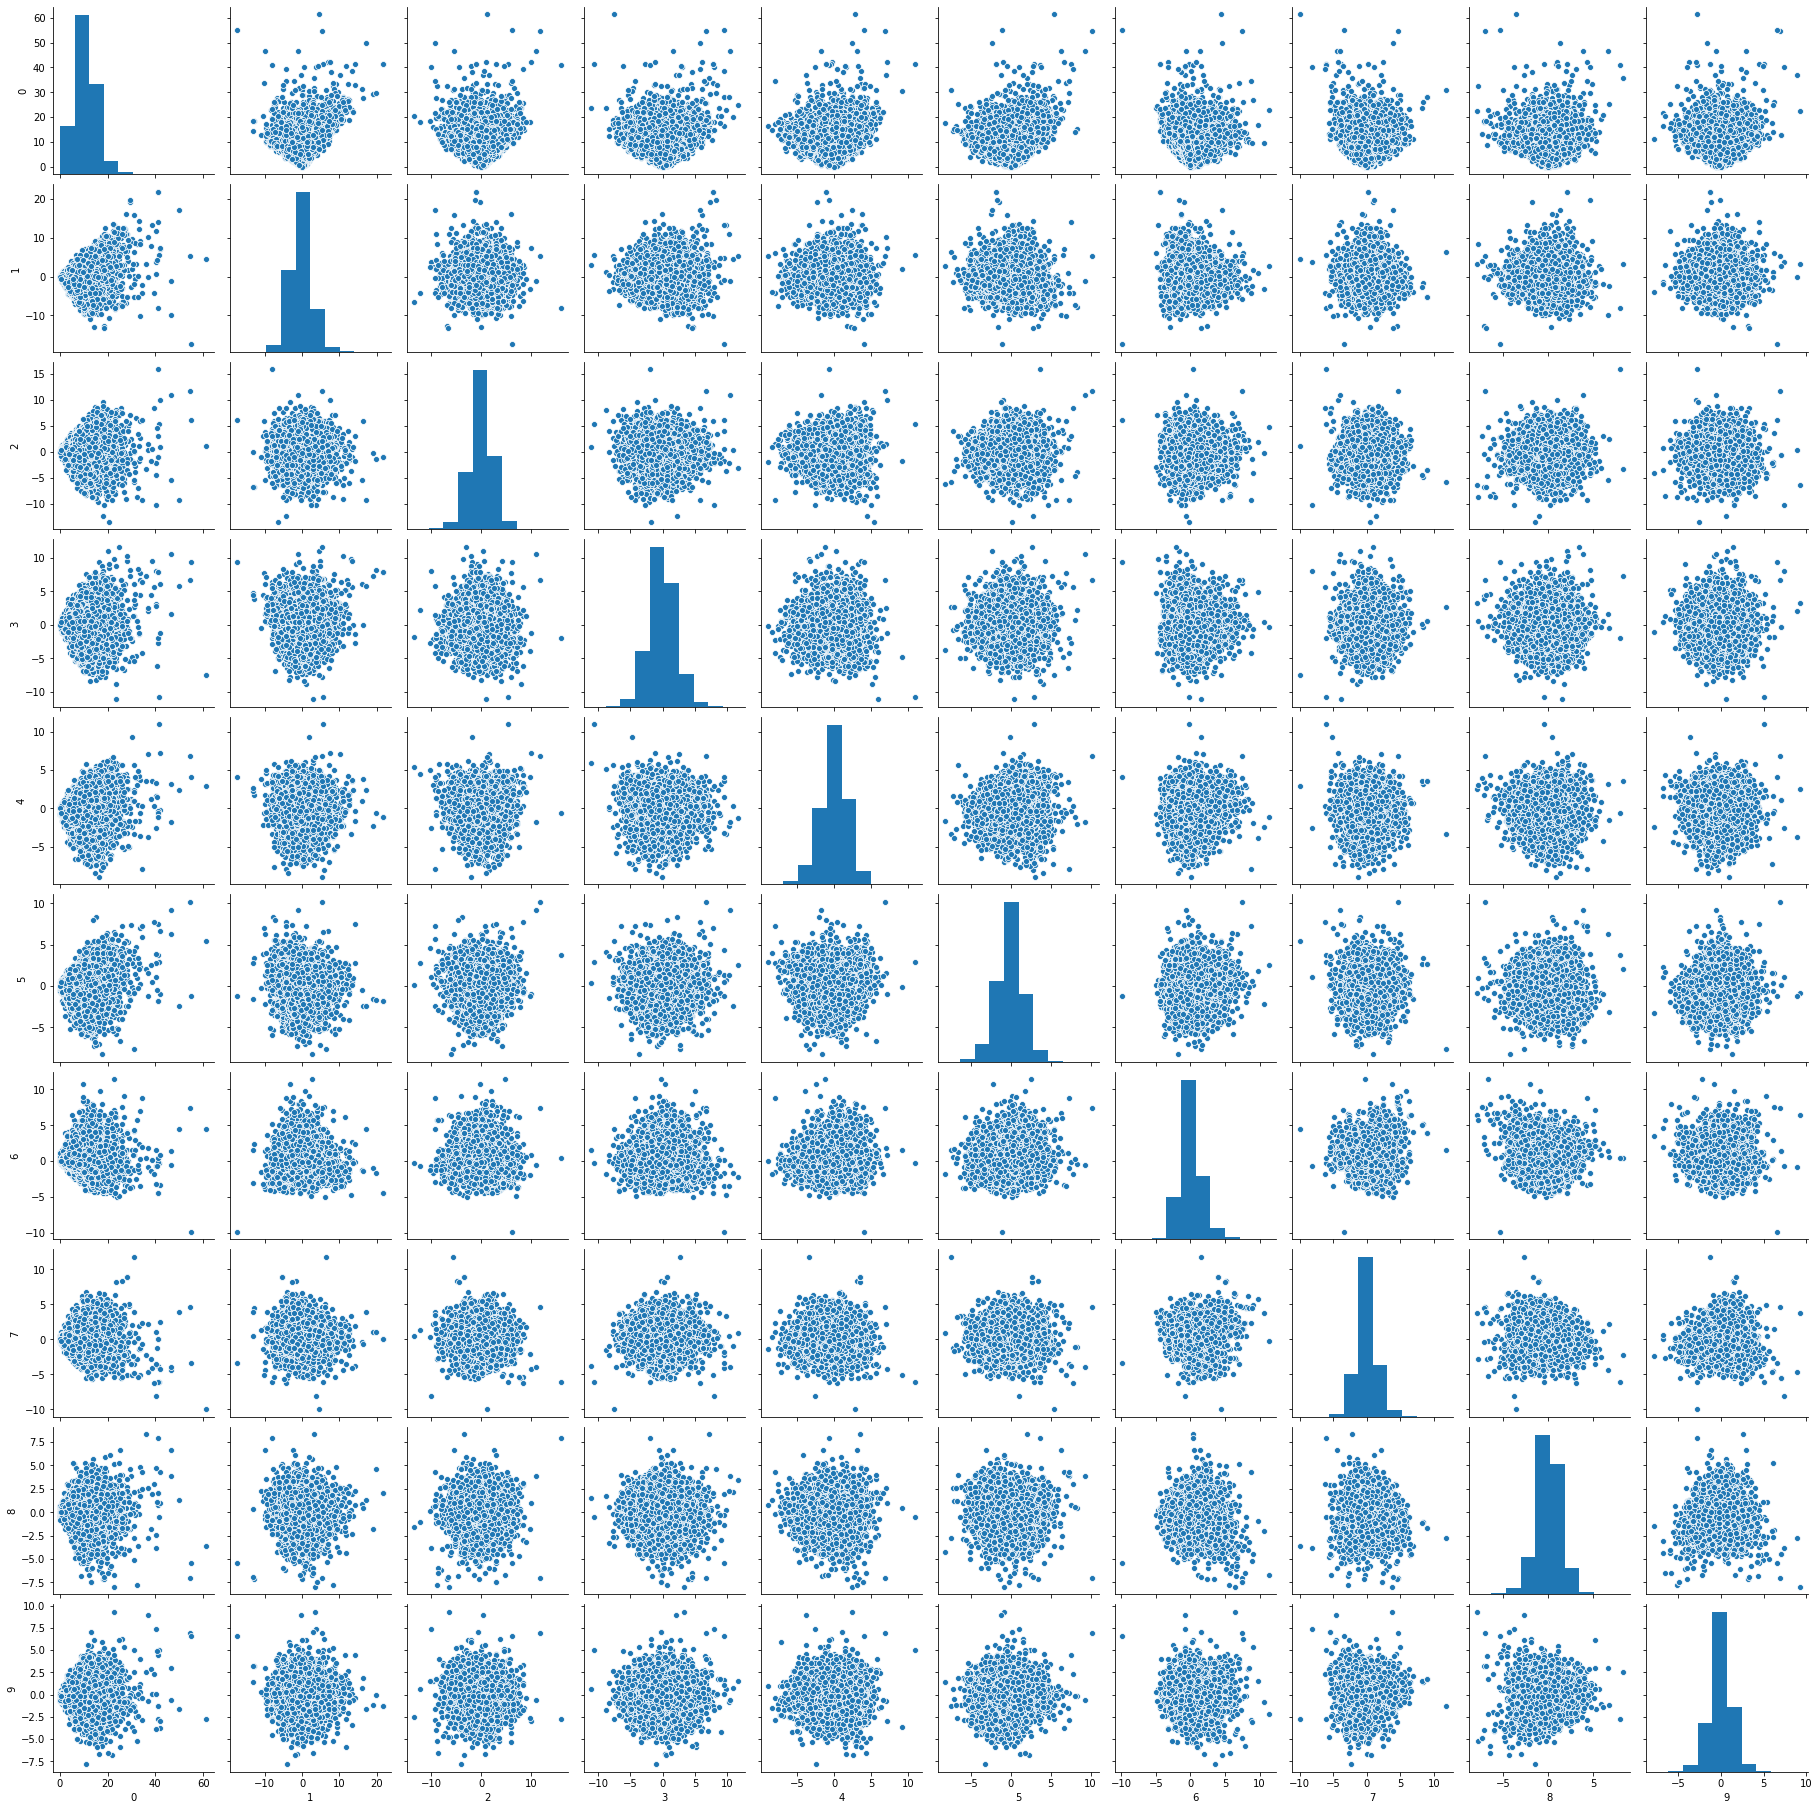

In [20]:
sns.pairplot(pd.DataFrame(svd_X))

What **words** are most strongly aligned with the first 3 dimensions?  The `vocabulary_` field on a vectorizer contains a dictionary mapping terms to feature indices. You need to invert this mapping (map indices to terms) in order to look up the term for a column of your reduced matrix.

In [29]:
vocab = pd.Series(svd.named_steps['tokenize'].vocabulary_)
vocab

unleashed      26716
web            27759
tablet         24789
integration    13171
into           13431
               ...  
coling          4939
acl             1012
cvir            6405
novick         17138
boy             3441
Length: 28374, dtype: int64

In [41]:
vocab.index.name='word'
words = vocab.to_frame(name='index').reset_index().set_index('index').sort_index()
words

,word
index,
0,00
1,000
2,000358
3,000m2
4,001
...,...
28369,zurich
28370,zwerm
28371,zydeco


Let's make a data frame.  We're going to transpose the components, so columns are dimensions; then put a word index on it.

In [42]:
svd_df = pd.DataFrame(svd.named_steps['svd'].components_.T, index=words['word'])
svd_df

,0,1,2,3,4,5,6,7,8,9
word,,,,,,,,,,
00,0.000005,-0.000001,-0.000042,0.000017,0.000025,0.000013,-0.000039,0.000008,-0.000050,0.000029
000,0.000802,-0.001031,0.001057,-0.001679,-0.000854,-0.000316,-0.001986,-0.000951,0.000706,-0.000331
000358,0.000004,0.000004,0.000024,-0.000030,-0.000032,-0.000010,0.000003,0.000012,-0.000060,-0.000019
000m2,0.000007,-0.000010,-0.000003,0.000056,0.000040,0.000014,-0.000018,-0.000011,-0.000033,0.000078
001,0.000032,0.000008,-0.000013,0.000145,-0.000043,-0.000103,-0.000114,0.000055,0.000288,0.000073
...,...,...,...,...,...,...,...,...,...,...
zurich,0.000026,-0.000019,0.000031,0.000047,-0.000041,0.000216,0.000034,0.000035,0.000124,-0.000027
zwerm,0.000012,-0.000021,0.000031,-0.000067,-0.000032,-0.000102,0.000189,0.000119,0.000048,0.000207
zydeco,0.000034,-0.000190,-0.000093,0.000132,-0.000091,0.000143,-0.000165,0.000071,0.000097,0.000059


What are the most important words on the first component?

In [44]:
svd_df[0].nlargest(10)

word
the     0.578024
of      0.425843
and     0.389527
to      0.303962
in      0.235221
for     0.148719
we      0.131305
that    0.123885
with    0.101644
is      0.099558
Name: 0, dtype: float64

And the second?

In [46]:
svd_df[1].nlargest(10)

word
the          0.697922
of           0.077968
was          0.022329
interface    0.020788
user         0.018603
is           0.018112
system       0.015926
model        0.012798
display      0.009539
task         0.009312
Name: 1, dtype: float64

And the third?

In [47]:
svd_df[2].nlargest(10)

word
of               0.610352
and              0.257136
design           0.064227
research         0.030398
social           0.028797
hci              0.025376
analysis         0.023038
implications     0.013666
practices        0.012915
understanding    0.012735
Name: 2, dtype: float64

**Exercise:** what happens if you remove stop words?